In [1]:

from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode




In [2]:
# Training set: Data augmentation and normalization
# Validation set: Normalization

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/tiny-imagenet-5'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

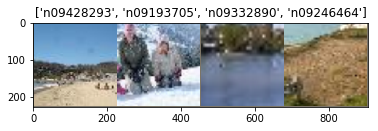

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])



In [3]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=50):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0] * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [6]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

In [11]:
# Load a pretrained model and reset final fully connected layer.

model_ft = models.resnet34(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 5)

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [12]:
# Train and evaluate
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=50)


Epoch 0/49
----------
train Loss: 1.5544 Acc: 0.4136
val Loss: 3.5515 Acc: 0.1560

Epoch 1/49
----------
train Loss: 1.4134 Acc: 0.4632
val Loss: 2.5573 Acc: 0.2680

Epoch 2/49
----------
train Loss: 1.2451 Acc: 0.5160
val Loss: 3.3437 Acc: 0.2120

Epoch 3/49
----------
train Loss: 1.1507 Acc: 0.5580
val Loss: 4.1745 Acc: 0.1880

Epoch 4/49
----------
train Loss: 1.0612 Acc: 0.5856
val Loss: 4.2942 Acc: 0.1880

Epoch 5/49
----------
train Loss: 1.0394 Acc: 0.5996
val Loss: 3.0443 Acc: 0.2320

Epoch 6/49
----------
train Loss: 1.0087 Acc: 0.6100
val Loss: 2.5973 Acc: 0.3120

Epoch 7/49
----------
train Loss: 0.8415 Acc: 0.6756
val Loss: 4.1619 Acc: 0.1760

Epoch 8/49
----------
train Loss: 0.7990 Acc: 0.6984
val Loss: 4.0654 Acc: 0.1840

Epoch 9/49
----------
train Loss: 0.7755 Acc: 0.7020
val Loss: 3.4480 Acc: 0.2280

Epoch 10/49
----------
train Loss: 0.7753 Acc: 0.7064
val Loss: 4.0887 Acc: 0.1920

Epoch 11/49
----------
train Loss: 0.7472 Acc: 0.7136
val Loss: 4.0053 Acc: 0.2480

Ep

In [13]:
# ConvNet as fixed feature extractor
# Here, we need to freeze all the network except the final layer. 
# We need to set requires_grad == False to freeze the parameters 
# so that the gradients are not computed in backward().

model_conv = torchvision.models.resnet34(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 5)

if use_gpu:
    model_conv = model_conv.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)




In [14]:
# Train and evaluate. 
model_conv = train_model(model_conv, criterion, optimizer_conv,\
                         exp_lr_scheduler, num_epochs=50)

Epoch 0/49
----------
train Loss: 1.4630 Acc: 0.4236
val Loss: 3.5070 Acc: 0.1400

Epoch 1/49
----------
train Loss: 1.4196 Acc: 0.4796
val Loss: 3.6788 Acc: 0.1520

Epoch 2/49
----------
train Loss: 1.3344 Acc: 0.4900
val Loss: 3.7081 Acc: 0.1360

Epoch 3/49
----------
train Loss: 1.3685 Acc: 0.4876
val Loss: 2.8746 Acc: 0.2480

Epoch 4/49
----------
train Loss: 1.3670 Acc: 0.4972
val Loss: 2.6991 Acc: 0.2960

Epoch 5/49
----------
train Loss: 1.3525 Acc: 0.5044
val Loss: 4.1459 Acc: 0.0920

Epoch 6/49
----------
train Loss: 1.3660 Acc: 0.5004
val Loss: 2.8362 Acc: 0.2360

Epoch 7/49
----------
train Loss: 1.1023 Acc: 0.5716
val Loss: 3.0089 Acc: 0.2080

Epoch 8/49
----------
train Loss: 1.0827 Acc: 0.5668
val Loss: 3.1229 Acc: 0.2160

Epoch 9/49
----------
train Loss: 1.1039 Acc: 0.5608
val Loss: 2.8669 Acc: 0.2120

Epoch 10/49
----------
train Loss: 1.0916 Acc: 0.5660
val Loss: 3.1753 Acc: 0.1800

Epoch 11/49
----------
train Loss: 1.0837 Acc: 0.5744
val Loss: 2.9590 Acc: 0.2040

Ep

In [16]:
torch.save(model_ft.state_dict(),'model_ft')
torch.save(model_conv.state_dict(),'model_conv')